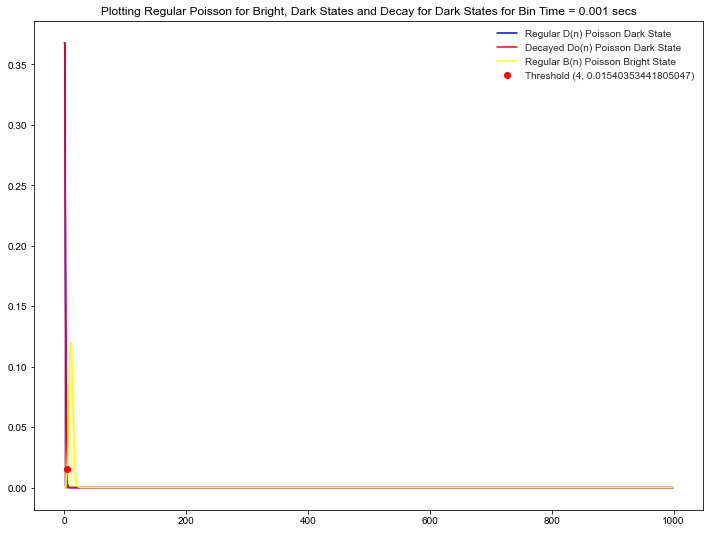

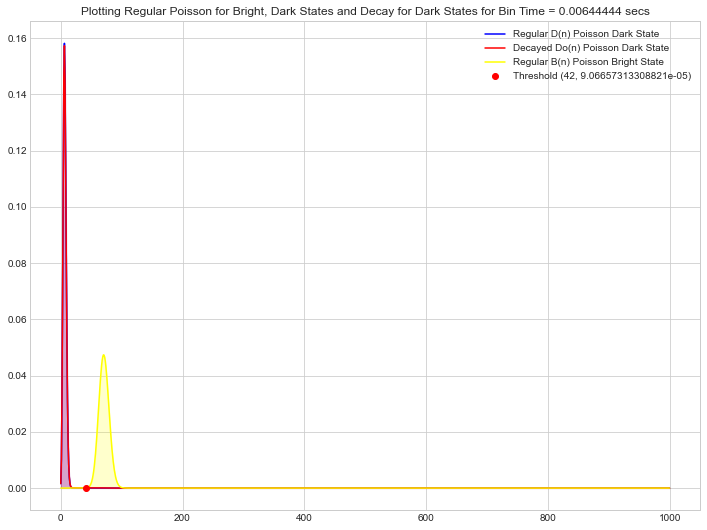

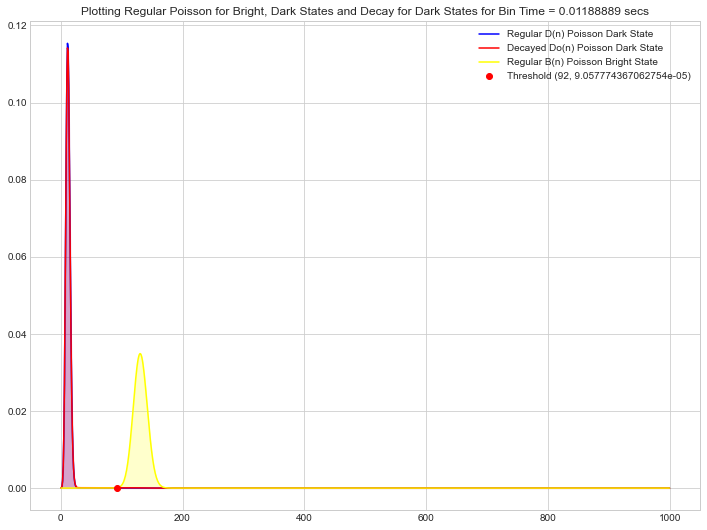

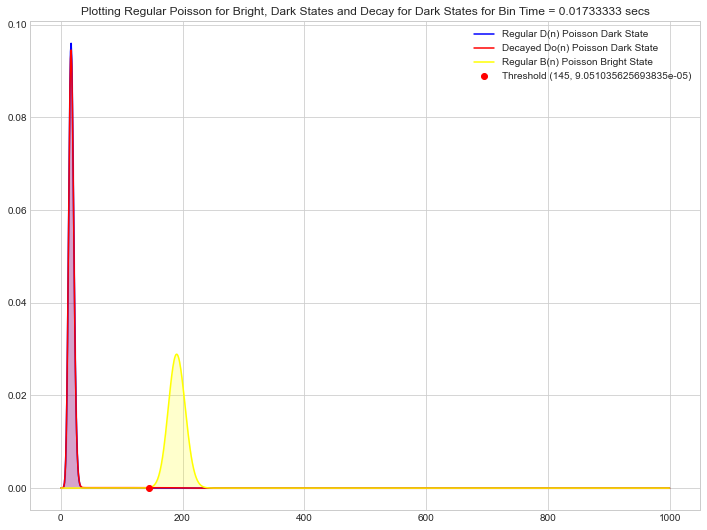

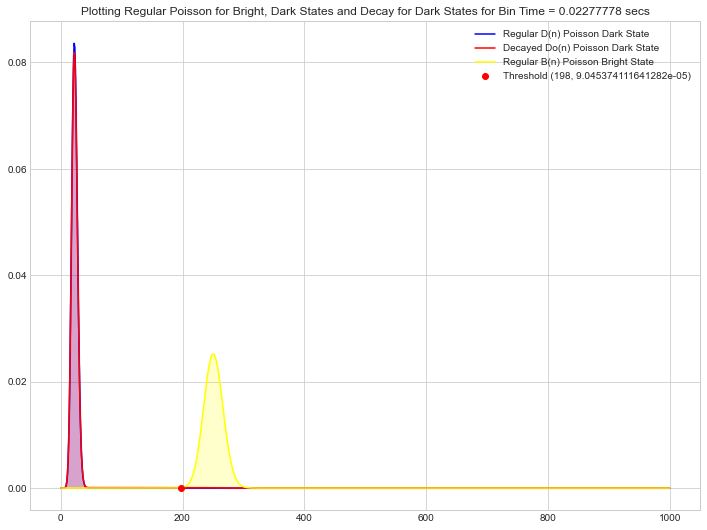

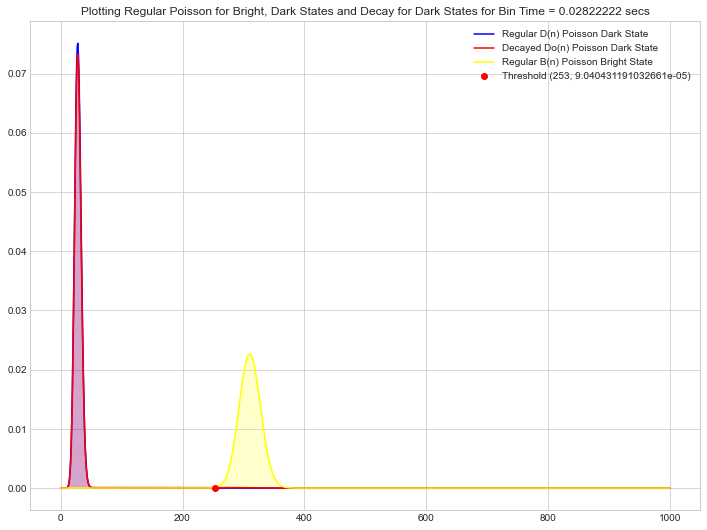

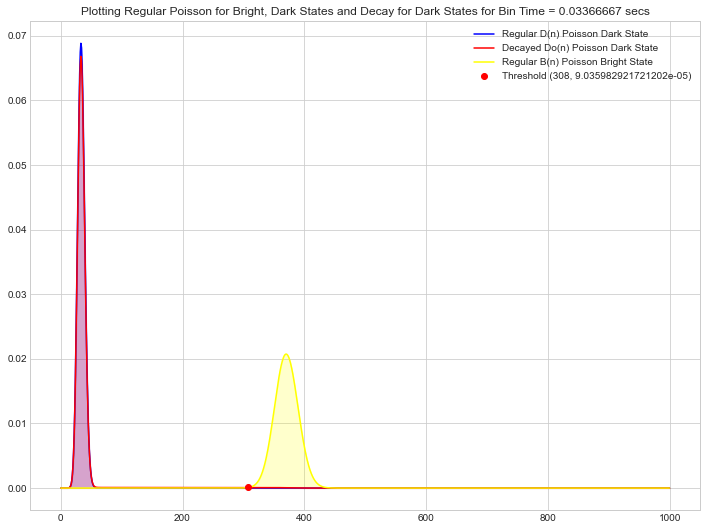

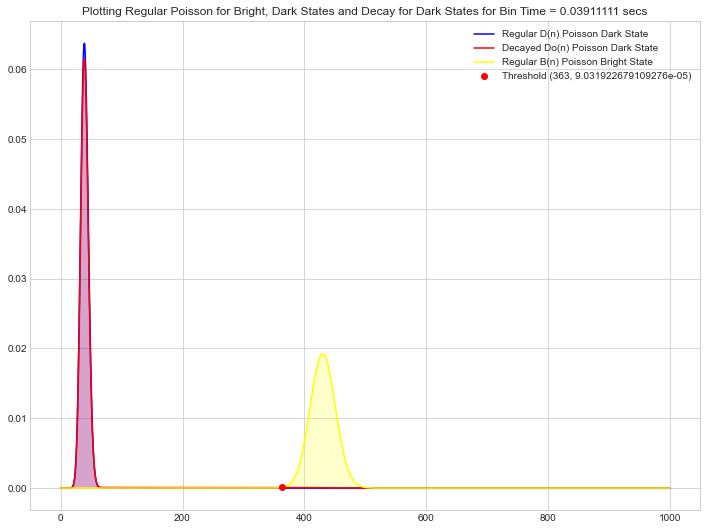

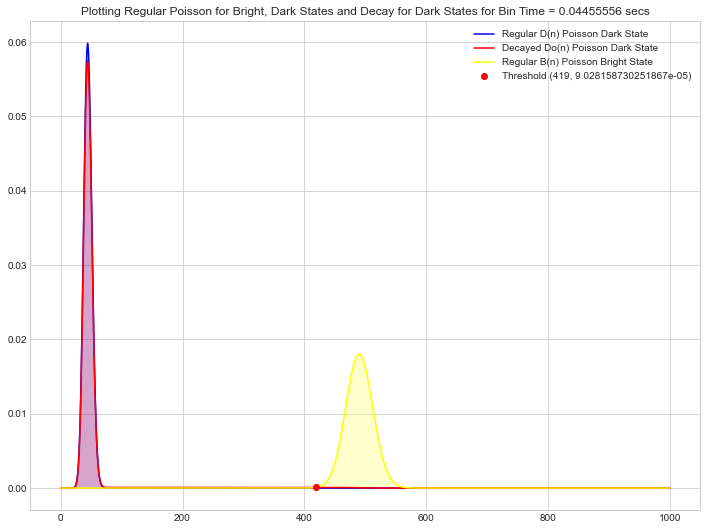

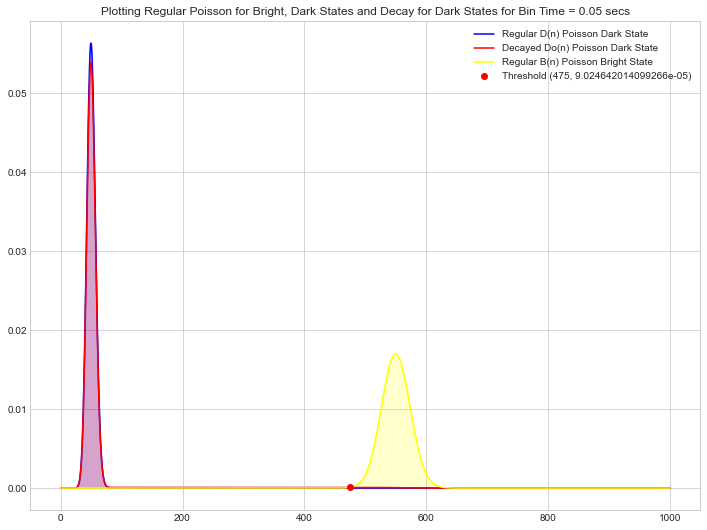

In [1]:
# Created By  : Katharine Lundblad
# Created Date: 4/05/22
# version ='1.0'
# ---------------------------------------------------------------------------
""" Calculates bin time for a trapped-ion detector given a 
    specified fidelity or probability of predicting the occurrence
    of an ion or its dark state. Plots Fidelity vs. Time and Threshold
    vs. time, probabilities are calculated analytically"""  
# ---------------------------------------------------------------------------
# Imports numpy, math, matplotlib, scipy.special, scipy.integrate
# ---------------------------------------------------------------------------
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.special as sc
from scipy.integrate import trapz
from scipy.stats import poisson
from scipy.special import factorial, gamma

# bin_times = np.linspace(0, 0.00005, 20)
bin_times = np.linspace(0.001, 0.05, 10)
# empty arrays for fidelities and thresholds
fidelities = np.array([])
thresholds = np.array([])
decay_thresholds = np.array([])
fidelity_time_dict = {}
thresh_time_dict = {}
poisson_B = np.array([])


R_B = float(1e4) # count rate of bright spots
R_D = float(1e3) # count rate of dark spots
tau = 1.1 # tau for decay of dark state, factor in probability ion remains in shelved state through bin time


n_decay = np.arange(0, 1000, 1) # x values of n for the decayed Do(n) poisson distribution
# bin time is independent variable for fidelity and threshold functions but is a constant for poissonian probability distribution
for bin_time in bin_times:
    """
    Calculating Information for Fidelity and Threshold Calculations
    """
    
    lambda_mean_R_D = R_D * bin_time         # mean of poisson distribution, probability of dark spot
    lambda_mean_R_B = (R_B + R_D) * bin_time
    
    # threshold for considering bright state and dark state (ie. n >= thresh is bright n < thresh is dark)
    threshold = (R_B * bin_time) / math.log(1.0 + (R_B / R_D)) 
    # Portions of graph that overlap at the threshold value are calculated
    discrim_B = poisson.cdf(k = threshold, mu = lambda_mean_R_B)
    discrim_D = 1.0 - poisson.cdf(k = threshold, mu = lambda_mean_R_D)
    
    fidelity = 1.0 - (discrim_B + discrim_D) # fidelity is 1 - total discrimination error
    fidelities = np.append(fidelities, fidelity) # add new value to array
    thresholds = np.append(thresholds, threshold) 
    
    # add rounded values to dictionaries
    fidelity_time_dict[str(fidelity)] = bin_time
    thresh_time_dict[str(threshold)] = bin_time
    
    """
    Calculating Poissonian Distribution for Ion decay in dark state
    """ 
    # for every occurrence of particle, calculate factorial and find Xo term of decay equation
    n_factorial_arr = np.array([]) # array to store the factorial of n_values
    Xo_vals = np.array([]) # array to store each value computed in the integral for the Xo integral
    poisson_B_arr = np.array([])
    poisson_D_arr = np.array([])
    Decay_array = np.array([]) # array to store the probabilities for the decay values
    for n_value in n_decay:
        n_factorial = math.factorial(int(n_value))
        n_factorial_arr = np.append(n_factorial_arr, n_factorial)
        
        # finding non-decay poisson values
        poisson_B = poisson.pmf(k = n_value, mu = lambda_mean_R_B) # creating probability for each n_value in poissonian distribution
        poisson_D = poisson.pmf(k = n_value, mu = lambda_mean_R_D)
        poisson_B_arr = np.append(poisson_B_arr, poisson_B) # adding values to an array of poisson values
        poisson_D_arr = np.append(poisson_D_arr, poisson_D)
        
        # finding Xo constant in array
        Xo_bounds = np.arange(lambda_mean_R_D, lambda_mean_R_B, 0.001) # define bounds of dark spot mean -> bright spot mean
        neg_Xo_bounds = -1.0 * Xo_bounds # all values in Xo_bounds negated
        
        # density of means assuming t is continuous random variable
        dens_of_means = (1.0 / (R_B * tau)) * np.exp((Xo_bounds - ((R_D + R_B) * bin_time)) / (R_B * tau))
        # finding the Xo term of the decay function
        Xo_function = dens_of_means * poisson.pmf(k = n_value, mu = Xo_bounds) # function to be integrated
        Xo_value = trapz(Xo_function, Xo_bounds) # computes integral with discrete stepsize of 0.01
        Xo_vals = np.append(Xo_vals, Xo_value) # adds computed value to array, maps to n values
        
        # finding decay term of the dark state, using poisson.pmf as the poissonian term of the expression
        Decay = math.exp(-1.0 * bin_time / tau) * poisson.pmf(k = n_value, mu = R_D * bin_time)
        Decay_array = np.append(Decay_array, Decay)
    # calculates decay term of the dark state probability 
    
    # adds Xo and exponential decay value and stores all decay values in an array
    Do_array = np.array([])
    for index in range(0, len(Xo_vals)):
        Do = Xo_vals[index] + Decay_array[index] 
        Do_array = np.append(Do_array, Do) 
    

    """
    Plotting regular poisson and then decayed poisson layered over
    """
    # plotting poisson distribution for entire range of occurrences
    plt.style.use('seaborn-whitegrid')
    r_bin_time = round(bin_time, 8) # rounding bin_time to 7 decimal places for easier reading
    plt.figure(figsize = (12, 9))
    plt.title("Plotting Regular Poisson for Bright, Dark States and Decay for Dark States for Bin Time = " + str(r_bin_time) + " secs")
    
    
    plt.plot(n_decay, poisson_D_arr, c = 'blue', label = "Regular D(n) Poisson Dark State")
    plt.fill_between(x= n_decay, y1= poisson_D_arr, where= (0 <= n_decay)&(n_decay < len(n_decay)), color= "blue",
                     alpha= 0.2)

    # plots each poisson distribution corresponding to a bin time
    plt.plot(n_decay, Do_array, c = 'red', label = "Decayed Do(n) Poisson Dark State")
    plt.fill_between(x= n_decay, y1= Do_array, where= (0 <= n_decay)&(n_decay < len(n_decay)), color= "red",
                     alpha= 0.2)
    plt.plot(n_decay, poisson_B_arr, c = 'yellow', label = "Regular B(n) Poisson Bright State")
    plt.fill_between(x= n_decay, y1= poisson_B_arr, where= (0 <= n_decay)&(n_decay < len(n_decay)), color= "yellow",
                     alpha= 0.2)
    # finds the indexes of intersection of the decay array and the poisson_B
    idx = np.argwhere(np.diff(np.sign(Do_array - poisson_B_arr))).flatten()
    
    # setting threshold to zero if no intersection found
    if (len(idx) == 0): 
        decayed_threshold = 0
        first_index_idx = 0
    else:
        first_index_idx = idx[0] # first occurrence of an intersection between the graphs
        decayed_threshold = n_decay[first_index_idx] # finds closest x integer value to the intersection of curves
    
    # Plotting threshold, adding legend for graphs, and creating array of thresholds for the real decay dark states vs bright states
    plt.plot(decayed_threshold, Do_array[first_index_idx], 'ro', label = "Threshold (" + str(decayed_threshold) + ", " + str(Do_array[first_index_idx]) + ")")
    plt.legend()
    decay_thresholds = np.append(decay_thresholds, decayed_threshold) # adding threshold to an array
    plt.show()
  

"""
Calculates Fidelity for decayed values
"""
decay_fidelities = np.array([])
n_decay = n_decay.astype(int)
for index in range(0, len(decay_thresholds)): # will use indexes of thresholds 
    # first summation of bright discrimination error
    threshold = decay_thresholds[index]
    if (threshold >= 0): 
        index_thresh = int(np.where(n_decay == threshold)[0]) # location of the threshold in the n values array
    else:
        index_thresh = 0
    Bright_X_bounds = n_decay[0:index_thresh]
    bright_discrim = np.sum(poisson_B_arr[0:index_thresh])
    # second summation of dark discrimination error
    Dark_X_bounds = n_decay[index_thresh:len(n_decay)]
    dark_discrim = np.sum(Do_array[index_thresh: len(n_decay)])
    decay_fidelity = 1.0 - (bright_discrim + dark_discrim)
    decay_fidelities = np.append(decay_fidelities, decay_fidelity)
    
    


        


In [ ]:
"""
Plotting fidelity and threshold vs time of regular on top of decayed
"""
plt.style.use('seaborn-whitegrid')
# plotting fidelity
plt.figure(figsize = (12, 9))
plt.scatter(bin_times, np.log10(1-fidelities), c = 'blue', linewidths = 0.1) 
plt.scatter(bin_times, np.log10(1-decay_fidelities), c = 'black') 
plt.ylabel("Fidelity")
plt.xlabel("Bin Time (s)")
plt.title("Time vs. Fidelity of Ion Detection")

# plotting threshold
plt.figure(figsize = (12, 9))
plt.scatter(bin_times, thresholds, c = 'red', linewidths = 0.1) 
plt.scatter(bin_times, decay_thresholds, c = 'black') 
plt.ylabel("Threshold (occurrences)")
plt.xlabel("Bin Time (s)")
plt.title("Time vs. Threshold of Ion Detection")

plt.show()
print(decay_fidelities)
print(fidelities)

In [ ]:
    
# """
# Plotting fidelity and threshold vs time of regular on top of decayed
# """
# plt.style.use('seaborn-whitegrid')
# # plotting fidelity
# plt.figure(figsize = (12, 9))
# plt.scatter(bin_times, fidelities, c = 'blue', linewidths = 0.1) 
# plt.scatter(bin_times, decay_fidelities, c = 'black') 
# plt.ylabel("Fidelity")
# plt.xlabel("Bin Time (s)")
# plt.title("Time vs. Fidelity of Ion Detection")

# # plotting threshold
# plt.figure(figsize = (12, 9))
# plt.scatter(bin_times, thresholds, c = 'red', linewidths = 0.1) 
# plt.scatter(bin_times, decay_thresholds, c = 'black') 
# plt.ylabel("Threshold (occurrences)")
# plt.xlabel("Bin Time (s)")
# plt.title("Time vs. Threshold of Ion Detection")

# plt.show()

# """
# Plotting log of fidelity vs time past 80 percent
# """
# fidelities[0] = 1
# index_above_50 = int(np.where(fidelities >= 0.5)[0][0])
# index_at_100 = int(np.where(fidelities <= 1.0)[-1][-1])
# print(len(fidelities), len(bin_times))

# dindex_above_50 = int(np.where(decay_fidelities >= 0.5)[0][0])
# dindex_at_100 = int(np.where(decay_fidelities <= 1.0)[-1][-1])
# large_fidelities = fidelities[int(index_above_50): int(index_at_100)]

# large_decay_fidelities = decay_fidelities[int(dindex_above_50): int(dindex_at_100)]
# sliced_bin_times = bin_times[int(index_above_50):int(index_at_100)]
# dsliced_bin_times = bin_times[int(dindex_above_50):int(dindex_at_100)]
# plt.style.use('seaborn-whitegrid')
# # plotting fidelity

# # for large_fidelity in large_fidelities:
# #     print(math.log(large_fidelity))
# plt.figure(figsize = (12, 9))
# log_fidelities = np.log(large_fidelities.astype(float))
# log_decay_fidelities = np.log(large_decay_fidelities.astype(float))

# plt.scatter(sliced_bin_times, np.log(large_fidelities.astype(float)), c = 'blue', linewidths = 0.1) 
# plt.scatter(dsliced_bin_times, np.log(large_decay_fidelities.astype(float)), c = 'black')

# plt.ylabel("log(Fidelity)")
# plt.xlabel("Bin Time (s)")
# plt.title("Time vs. log(Fidelity) of Ion Detection")
# plt.show()poisson

# """
# User Input for Fidelity printing Bin Time
# """
# new_attempt = True
# while (new_attempt == True): # loops however many times user wants to obtain new bin time
#     input_fidelity = input("Enter input fidelity or press enter: ")
#     input_thresh = input("Enter input threshold or press enter: ")

#     min_fidelity_diff = 100.0 # beginning value for minimum fidelity difference to be overwritten
#     return_fidelity = "0.0"

#     for fidelity in fidelity_time_dict.keys(): # finds the value in dictionary closest to the value entered

#         input_vs_calculated_diff = abs(float(input_fidelity) - float(fidelity)) # stores difference between inputted value and calculated value
#         temp_diff = min_fidelity_diff # stores old minimum to be compared to new minimum
#         min_fidelity_diff = abs(min(input_vs_calculated_diff, min_fidelity_diff)) # compares diffs from previous value and current value

#         if (temp_diff != min_fidelity_diff): # if the old minimum not the same as current minimum
#             return_fidelity = fidelity # if new minimum error between input and calculated is found, store this as return value

#     return_time = fidelity_time_dict.get(return_fidelity) # gets given value of fidelity -> time dictionary to return


#     print("Bin time for " + str(input_fidelity) + " fidelity is: " + str(return_time))
    
#     # asks if user wants to input new value, y indicates yes, otherwise end running 
#     ask_new = input("New bin time? (y/n): ")
#     if (ask_new != "y"):
#         new_attempt = False 